<a href="https://colab.research.google.com/github/GabrielMSchmidt/MLP-Basico/blob/main/MLP-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Dataset

### Extração do Dataset

In [ ]:
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/dataset')

### Leitura do Dataset

In [ ]:
dataset_train = pd.read_csv('/dataset/pulsar_data_train.csv')
dataset_test = pd.read_csv('/dataset/pulsar_data_test.csv')

In [ ]:
dataset_train.shape

# https://www.kaggle.com/code/mohamedmosaadhadia/predicting-pulsar-stars  Codigo base

(12528, 9)

In [ ]:
dataset_train.columns=['Mean','SD','Kurtosis','Skewness','DM_SNR_Mean','DM_SMR_SD','DM-SNR Kurtosis','DM-SNR Skewness','Target_class']
dataset_test.columns=['Mean','SD','Kurtosis','Skewness','DM_SNR_Mean','DM_SMR_SD','DM-SNR Kurtosis','DM-SNR Skewness','Target_class']
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mean             12528 non-null  float64
 1   SD               12528 non-null  float64
 2   Kurtosis         10793 non-null  float64
 3   Skewness         12528 non-null  float64
 4   DM_SNR_Mean      12528 non-null  float64
 5   DM_SMR_SD        11350 non-null  float64
 6   DM-SNR Kurtosis  12528 non-null  float64
 7   DM-SNR Skewness  11903 non-null  float64
 8   Target_class     12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


In [ ]:
dataset_train.duplicated().sum()

0

In [ ]:
dataset_train.isnull().sum()

,0
Mean,0
SD,0
Kurtosis,1735
Skewness,0
DM_SNR_Mean,0
DM_SMR_SD,1178
DM-SNR Kurtosis,0
DM-SNR Skewness,625
Target_class,0


<ipython-input-9-00342b749178>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


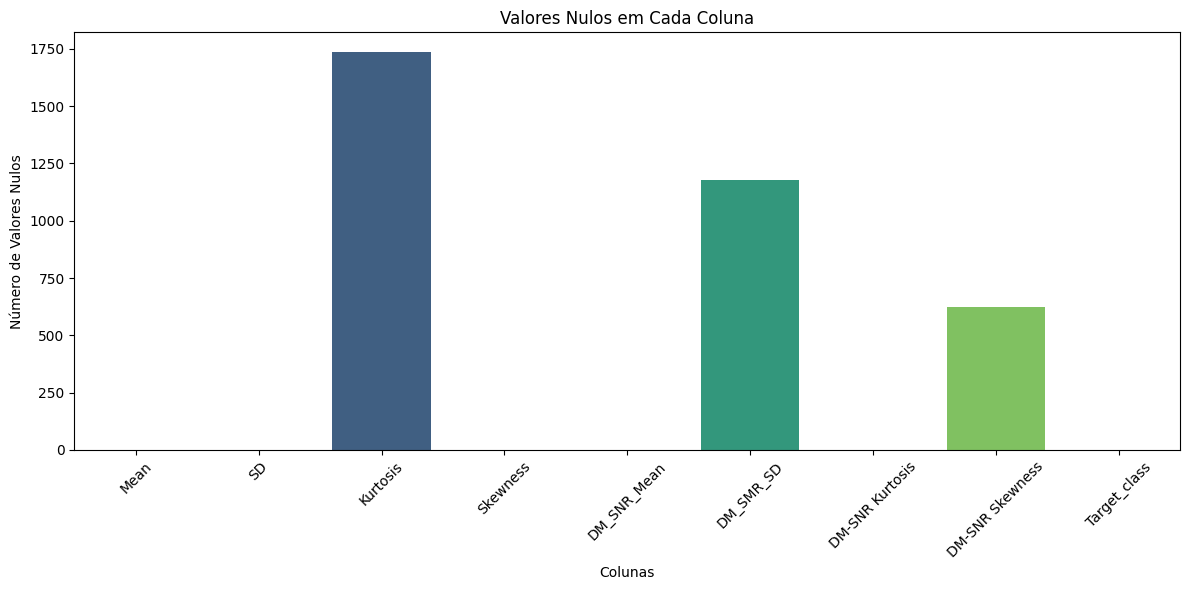

In [ ]:
missing_values = dataset_train.isnull().sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Valores Nulos em Cada Coluna')
plt.xlabel('Colunas')
plt.ylabel('Número de Valores Nulos')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('valores_nulos.png')
plt.show()

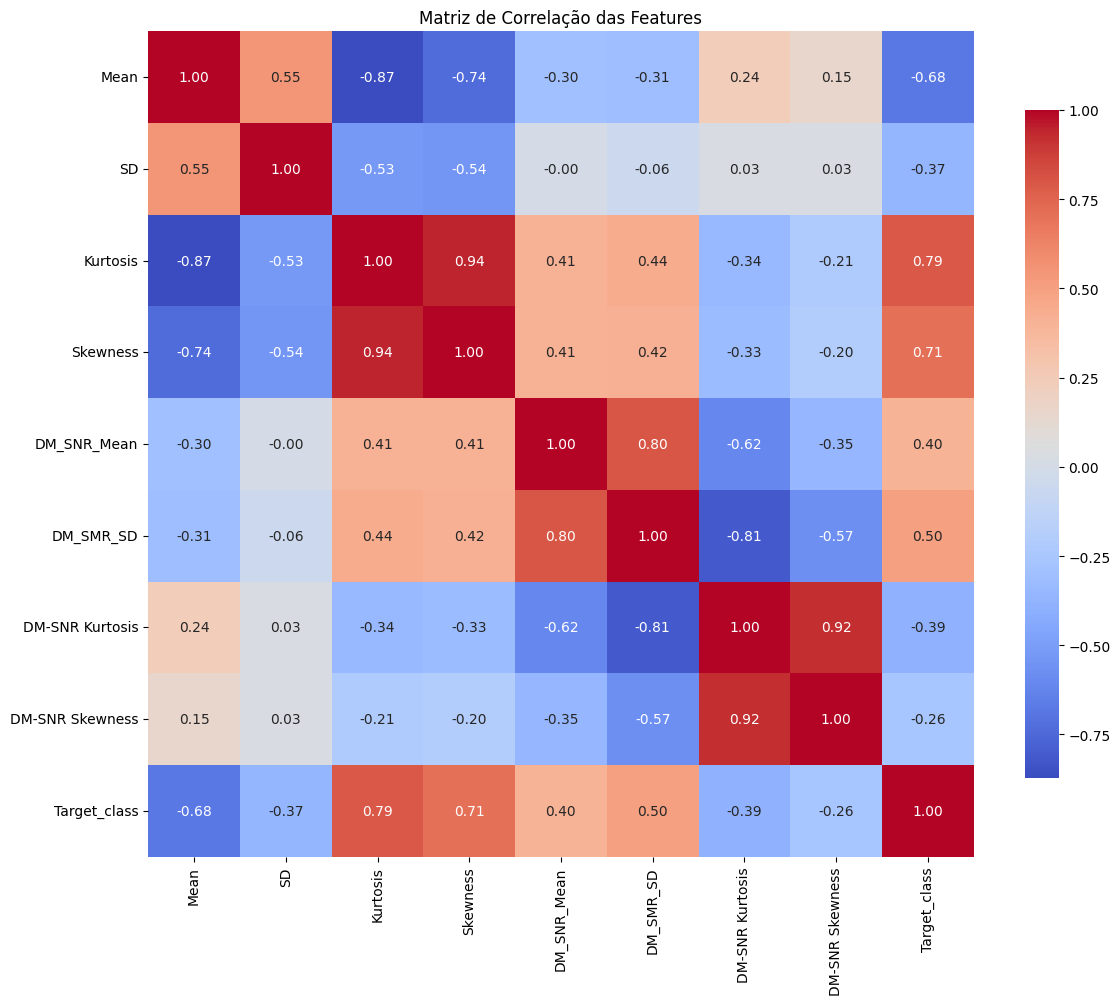

In [ ]:
correlation_matrix = dataset_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação das Features')
plt.tight_layout()

plt.savefig('matriz_correlacao.png')
plt.show()

# Rede Neural


In [ ]:
class MultiLayerPerceptron:
    def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int = 10, output_neurons: int = 1):
        np.random.seed(8)
        self.x = x
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.input_neurons = self.x.shape[1]

        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output_neurons))
        self.z1 = 0
        self.f1 = 0

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.z1 = x.dot(self.W1) + self.B1
        self.f1 = np.tanh(self.z1)

        z2 = self.f1.dot(self.W2) + self.B2
        self.output = 1 / (1 + np.exp(-z2))
        return self.output

    def loss(self) -> float:
        predictions = self.output.flatten()
        labels = self.y.flatten()
        return -np.mean(labels * np.log(predictions + 1e-12) + (1 - labels) * np.log(1 - predictions + 1e-12))

    def backpropagation(self, learning_rate: float) -> None:
      delta2 = self.output - self.y.reshape(-1, 1)

      dW2 = self.f1.T.dot(delta2) / self.x.shape[0]
      dB2 = np.sum(delta2, axis=0, keepdims=True) / self.x.shape[0]

      delta1 = delta2.dot(self.W2.T) * (1 - np.power(self.f1, 2))
      dW1 = self.x.T.dot(delta1) / self.x.shape[0]
      dB1 = np.sum(delta1, axis=0, keepdims=True) / self.x.shape[0]

      self.W1 -= learning_rate * dW1
      self.W2 -= learning_rate * dW2
      self.B1 -= learning_rate * dB1
      self.B2 -= learning_rate * dB2

    def show_plot(self, predictions):
        if self.x.shape[1] == 2:
            plt.scatter(self.x[:, 0], self.x[:, 1], s=50, c=predictions, cmap='cool', alpha=0.7)
            plt.show()

    def fit(self, epochs: int, lr: float, show_plot: bool = False):
        for epoch in range(epochs):
            outputs = self.forward(self.x)
            loss = self.loss()
            self.backpropagation(lr)

            predictions = (outputs > 0.5).astype(int)
            correct = (predictions.flatten() == self.y.flatten()).sum()
            accuracy = correct / self.y.shape[0]

            if int((epoch + 1) % (epochs / 10)) == 0 or epoch == epochs - 1:
                print(f'Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.3f} Loss: {loss:.5f}')
                if show_plot:
                    self.show_plot(predictions)

        return predictions

    def predict(self, x: np.ndarray) -> np.ndarray:
        outputs = self.forward(x)
        predictions = (outputs > 0.5).astype(int)
        return predictions.flatten()

# Primeiro Teste

<ipython-input-12-700236ca5863>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


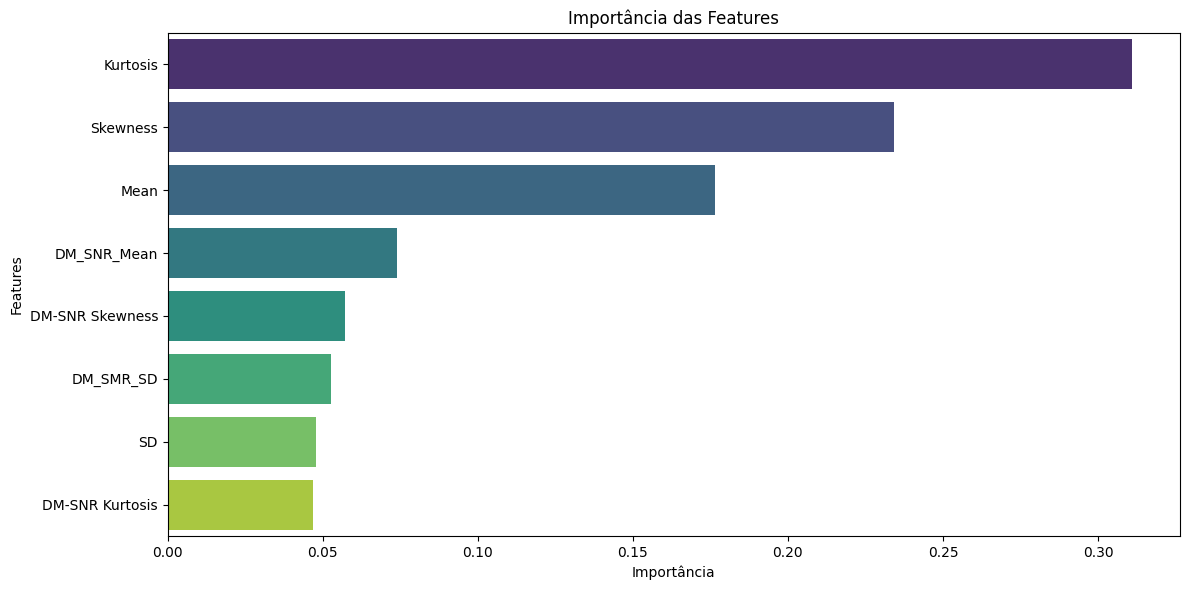

In [ ]:
# Definindo variáveis independentes e dependentes
X = dataset_train.drop(columns=['Target_class'])
Y = dataset_train['Target_class']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)

# Obter a importância das features
importances = model.feature_importances_
feature_names = X.columns

# Criar um DataFrame para visualizar a importância das features
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()

# Salvar o gráfico
plt.savefig('importancia_features.png')
plt.show()

In [ ]:
from google.colab import files
files.download('confusion_matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_train.head()

,Mean,SD,Kurtosis,Skewness,DM_SNR_Mean,DM_SMR_SD,DM-SNR Kurtosis,DM-SNR Skewness,Target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [ ]:
missing_data_rows = dataset_train[dataset_train.isnull().any(axis=1)]
print(missing_data_rows)

             Mean         SD  Kurtosis  Skewness  DM_SNR_Mean  DM_SMR_SD  \
3      156.398438  48.865942 -0.215989 -0.171294    17.471572        NaN   
5      121.007812  47.176944  0.229708  0.091336     2.036789        NaN   
6       79.343750  42.402174  1.063413  2.244377   141.641304        NaN   
9      109.156250  47.002234  0.394182  0.190296     4.578595        NaN   
13     128.734375  48.695560       NaN  0.307803     5.307692  25.162295   
...           ...        ...       ...       ...          ...        ...   
12503  132.335938  52.273362 -0.095982 -0.417207     4.736622        NaN   
12504   85.015625  36.717244       NaN  2.503142     3.262542  21.981437   
12506  113.750000  51.916098  0.215305 -0.216608     1.678930  11.105255   
12513  127.609375  53.509379       NaN -0.564330     0.527592   8.985407   
12524  115.617188  46.784600  0.218177  0.226757     6.140468        NaN   

       DM-SNR Kurtosis  DM-SNR Skewness  Target_class  
3             2.958066         

In [ ]:
dataset_train = dataset_train.fillna(dataset_train.mean())
dataset_test = dataset_test.fillna(dataset_test.mean())

In [ ]:
x = dataset_train.to_numpy()[:, 0:8]
y = dataset_train.to_numpy()[:, 8]

unique = np.unique(y, return_counts = True)
for label, qt_label in zip(unique[0], unique[1]):
    print(f'Label: {label}\t Counts: {qt_label}')

Label: 0.0	 Counts: 11375
Label: 1.0	 Counts: 1153


In [ ]:
print(f'{x.shape = }, {y.shape = }')

x.shape = (12528, 8), y.shape = (12528,)


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)

In [ ]:
# Teste

from sklearn.model_selection  import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# check the shape of X_train and X_test

x_train.shape, x_test.shape

((10022, 8), (2506, 8))

In [ ]:
mlp = MultiLayerPerceptron(x_train, y_train, hidden_neurons=16, output_neurons=1)
mlp.fit(epochs=1000, lr=0.1, show_plot=False)

Epoch: [100 / 1000]  Accuracy: 0.925 Loss: 0.18809
Epoch: [200 / 1000]  Accuracy: 0.950 Loss: 0.14796
Epoch: [300 / 1000]  Accuracy: 0.958 Loss: 0.12930
Epoch: [400 / 1000]  Accuracy: 0.961 Loss: 0.11914
Epoch: [500 / 1000]  Accuracy: 0.964 Loss: 0.11258
Epoch: [600 / 1000]  Accuracy: 0.965 Loss: 0.10788
Epoch: [700 / 1000]  Accuracy: 0.967 Loss: 0.10432
Epoch: [800 / 1000]  Accuracy: 0.968 Loss: 0.10153
Epoch: [900 / 1000]  Accuracy: 0.969 Loss: 0.09932
Epoch: [1000 / 1000]  Accuracy: 0.970 Loss: 0.09755


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
# x_test = x_test.to_numpy()[:, 0:8]

# Prever os valores do conjunto de teste
y_pred = mlp.predict(x_test)

for i, star in enumerate(y_pred):
    print(f'Estela[{i + 1}]: É um pulsar') if star == 1 else None

Estela[4]: É um pulsar
Estela[15]: É um pulsar
Estela[19]: É um pulsar
Estela[28]: É um pulsar
Estela[37]: É um pulsar
Estela[57]: É um pulsar
Estela[60]: É um pulsar
Estela[68]: É um pulsar
Estela[103]: É um pulsar
Estela[161]: É um pulsar
Estela[168]: É um pulsar
Estela[212]: É um pulsar
Estela[237]: É um pulsar
Estela[247]: É um pulsar
Estela[272]: É um pulsar
Estela[291]: É um pulsar
Estela[318]: É um pulsar
Estela[329]: É um pulsar
Estela[335]: É um pulsar
Estela[354]: É um pulsar
Estela[356]: É um pulsar
Estela[360]: É um pulsar
Estela[376]: É um pulsar
Estela[383]: É um pulsar
Estela[417]: É um pulsar
Estela[447]: É um pulsar
Estela[449]: É um pulsar
Estela[452]: É um pulsar
Estela[454]: É um pulsar
Estela[472]: É um pulsar
Estela[479]: É um pulsar
Estela[480]: É um pulsar
Estela[494]: É um pulsar
Estela[526]: É um pulsar
Estela[528]: É um pulsar
Estela[535]: É um pulsar
Estela[536]: É um pulsar
Estela[541]: É um pulsar
Estela[547]: É um pulsar
Estela[551]: É um pulsar
Estela[55

In [ ]:
# Importando bibliotecas para métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Exibir as métricas
print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC-ROC: {auc:.2f}')


Acurácia: 0.97
Precisão: 0.94
Recall: 0.69
F1-Score: 0.80
AUC-ROC: 0.84


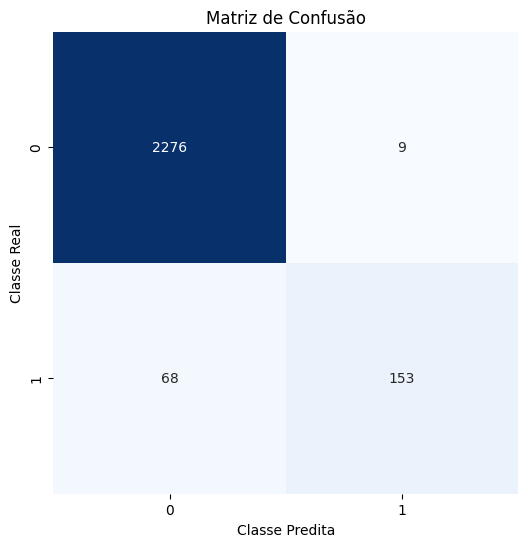

In [ ]:
from sklearn.metrics import confusion_matrix

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')

# Salvar a figura como arquivo PNG
plt.savefig("confusion_matrix.png")

# Exibir a matriz de confusão
plt.show()